In [1]:
import os

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from IPython.display import display, HTML, Image
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 20})

# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery
auth.authenticate_user()

In [2]:
project_id = 'mystic-sound-432708-h4'
if project_id == 'CHANGE-ME':
  raise ValueError('You must change project_id to your GCP project.')
os.environ["GOOGLE_CLOUD_PROJECT"] = project_id

# Read data from BigQuery into pandas dataframes.
def run_query(query, project_id=project_id):
  return pd.io.gbq.read_gbq(
      query,
      project_id=project_id,
      dialect='standard')

# set the dataset
# if you want to use the demo, change this to mimic_demo
dataset = 'mimiciv'

In [3]:
query="""
WITH adult_patients AS (
    SELECT subject_id
    FROM physionet-data.mimiciv_hosp.patients
    WHERE anchor_age >= 18
),

non_ckd_patients AS (
    SELECT DISTINCT subject_id
    FROM physionet-data.mimiciv_hosp.diagnoses_icd
    WHERE subject_id NOT IN (
        SELECT subject_id
        FROM physionet-data.mimiciv_hosp.diagnoses_icd
        WHERE LOWER(icd_code) LIKE '585%' -- CKD ICD-9 code
        AND icd_version = 9
    )
),

non_aki_patients AS (
    SELECT DISTINCT subject_id
    FROM physionet-data.mimiciv_hosp.diagnoses_icd
    WHERE subject_id NOT IN (
        SELECT subject_id
        FROM physionet-data.mimiciv_hosp.diagnoses_icd
        WHERE LOWER(icd_code) LIKE '584%' -- AKI ICD-9 code
        AND icd_version = 9
    )
),

creatinine_measurements AS (
    SELECT l.subject_id, l.hadm_id, l.charttime, l.valuenum
    FROM physionet-data.mimiciv_hosp.labevents l
    JOIN physionet-data.mimiciv_icu.icustays icu ON l.hadm_id = icu.hadm_id
    WHERE l.itemid = 50912 -- Creatinine item ID
    AND l.charttime <= TIMESTAMP_ADD(icu.intime, INTERVAL 72 HOUR)
),

patients_with_enough_creatinine_measurements AS (
    SELECT subject_id
    FROM creatinine_measurements
    GROUP BY subject_id
    HAVING COUNT(subject_id) >= 3
),

filtered_patients AS (
    SELECT adult_patients.subject_id, icu.intime
    FROM adult_patients
    JOIN non_ckd_patients USING (subject_id)
    JOIN non_aki_patients USING (subject_id)
    JOIN patients_with_enough_creatinine_measurements USING (subject_id)
    JOIN physionet-data.mimiciv_icu.icustays icu ON adult_patients.subject_id = icu.subject_id
),

physiological_data AS (
    SELECT
        f.subject_id,
        DATE_DIFF(l.charttime, f.intime, DAY) + 1 AS day,
        MAX(CASE WHEN l.itemid = 50912 THEN l.valuenum END) AS creatinine_max,
        MIN(CASE WHEN l.itemid = 50912 THEN l.valuenum END) AS creatinine_min,
        MAX(CASE WHEN l.itemid = 50809 THEN l.valuenum END) AS glucose_max,
        MIN(CASE WHEN l.itemid = 50809 THEN l.valuenum END) AS glucose_min,
        MAX(CASE WHEN l.itemid = 51222 THEN l.valuenum END) AS hemoglobin_max,
        MIN(CASE WHEN l.itemid = 51222 THEN l.valuenum END) AS hemoglobin_min,
        MAX(CASE WHEN l.itemid = 51265 THEN l.valuenum END) AS platelet_max,
        MIN(CASE WHEN l.itemid = 51265 THEN l.valuenum END) AS platelet_min,
        MAX(CASE WHEN l.itemid = 50971 THEN l.valuenum END) AS potassium_max,
        MIN(CASE WHEN l.itemid = 50971 THEN l.valuenum END) AS potassium_min,
        MAX(CASE WHEN l.itemid = 51275 THEN l.valuenum END) AS ptt_max,
        MIN(CASE WHEN l.itemid = 51275 THEN l.valuenum END) AS ptt_min,
        MAX(CASE WHEN l.itemid = 51237 THEN l.valuenum END) AS inr_max,
        MIN(CASE WHEN l.itemid = 51237 THEN l.valuenum END) AS inr_min,
        MAX(CASE WHEN l.itemid = 51006 THEN l.valuenum END) AS bun_max,
        MIN(CASE WHEN l.itemid = 51006 THEN l.valuenum END) AS bun_min,
        MAX(CASE WHEN l.itemid = 50893 THEN l.valuenum END) AS calcium_max,
        MIN(CASE WHEN l.itemid = 50893 THEN l.valuenum END) AS calcium_min,
        MAX(CASE WHEN l.itemid = 50825 THEN l.valuenum END) AS temp_max,
        MIN(CASE WHEN l.itemid = 50825 THEN l.valuenum END) AS temp_min
    FROM physionet-data.mimiciv_hosp.labevents l
    JOIN filtered_patients f ON l.subject_id = f.subject_id
    WHERE l.charttime <= TIMESTAMP_ADD(f.intime, INTERVAL 3 DAY)
    AND DATE_DIFF(l.charttime, f.intime, DAY) BETWEEN 0 AND 2
    GROUP BY f.subject_id, day
),

vital_signs_data AS (
    SELECT
        f.subject_id,
        DATE_DIFF(c.charttime, f.intime, DAY) + 1 AS day,
        MAX(CASE WHEN c.itemid = 220179 THEN c.valuenum END) AS systolic_bp_max,
        MIN(CASE WHEN c.itemid = 220179 THEN c.valuenum END) AS systolic_bp_min,
        MAX(CASE WHEN c.itemid = 220180 THEN c.valuenum END) AS diastolic_bp_max,
        MIN(CASE WHEN c.itemid = 220180 THEN c.valuenum END) AS diastolic_bp_min,
        MAX(CASE WHEN c.itemid = 220045 THEN c.valuenum END) AS heart_rate_max,
        MIN(CASE WHEN c.itemid = 220045 THEN c.valuenum END) AS heart_rate_min
    FROM physionet-data.mimiciv_icu.chartevents c
    JOIN filtered_patients f ON c.subject_id = f.subject_id
    WHERE c.charttime <= TIMESTAMP_ADD(f.intime, INTERVAL 3 DAY)
    AND DATE_DIFF(c.charttime, f.intime, DAY) BETWEEN 0 AND 2
    GROUP BY f.subject_id, day
),

patient_weight AS (
    SELECT
        subject_id,
        AVG(valuenum) AS weight
    FROM `physionet-data.mimiciv_icu.chartevents`
    WHERE itemid = 226512
    AND subject_id IN (SELECT subject_id FROM filtered_patients)
    GROUP BY subject_id
),

urine_output_data AS (
    SELECT
        f.subject_id,
        AVG(CAST(c.value AS FLOAT64)) / w.weight AS avg_urine_output_per_kg
    FROM physionet-data.mimiciv_icu.outputevents c
    JOIN filtered_patients f ON c.subject_id = f.subject_id
    JOIN patient_weight w ON f.subject_id = w.subject_id
    WHERE c.itemid IN (40055, 43175, 40069, 40094, 40715, 226559, 226560, 226561, 226563, 226564, 226565, 226567)
    AND DATE_DIFF(c.charttime, f.intime, DAY) = 0
    GROUP BY f.subject_id, w.weight
),

days AS (
    SELECT 1 AS day UNION ALL
    SELECT 2 UNION ALL
    SELECT 3
),



urine_output AS (
    SELECT
        c.subject_id,
        c.charttime,
        c.value AS urine_output,
        LEAD(c.charttime) OVER (PARTITION BY c.subject_id ORDER BY c.charttime) AS next_time,
        TIMESTAMP_DIFF(LEAD(c.charttime) OVER (PARTITION BY c.subject_id ORDER BY c.charttime), c.charttime, HOUR) AS hours_between
    FROM `physionet-data.mimiciv_icu.outputevents` c
    JOIN `physionet-data.mimiciv_icu.icustays` icu
    ON c.subject_id = icu.subject_id
    WHERE c.itemid IN (40055, 43175, 40069, 40094, 40715, 226559, 226560, 226561, 226563, 226564, 226565, 226567)
    AND c.subject_id IN (SELECT subject_id FROM filtered_patients)
    AND c.charttime BETWEEN icu.intime AND TIMESTAMP_ADD(icu.intime, INTERVAL 72 HOUR)
),






urine_output_per_kg_per_hour AS (
    SELECT
        u.subject_id,
        u.charttime,
        u.urine_output,
        w.weight,
        u.hours_between,
        (u.urine_output / (w.weight * u.hours_between)) AS urine_per_kg_per_hour
    FROM urine_output u
    JOIN patient_weight w ON u.subject_id = w.subject_id
    WHERE u.hours_between > 0
    AND u.subject_id IN (SELECT subject_id FROM filtered_patients)
),


aki_patients AS (
    SELECT
        subject_id,
        COUNTIF(urine_per_kg_per_hour < 0.5) AS low_urine_hours
    FROM urine_output_per_kg_per_hour
    GROUP BY subject_id
    HAVING low_urine_hours >= 6
    AND subject_id IN (SELECT subject_id FROM filtered_patients)
),


aki_status AS (
    SELECT
        p.subject_id,
        p.creatinine_min AS day1_creatinine_min,
        p2.creatinine_max AS day2_creatinine_max,
        p3.creatinine_max AS day3_creatinine_max,
        CASE
            WHEN (p2.creatinine_max - p.creatinine_min >= 0.3) OR (p3.creatinine_max - p.creatinine_min >= 0.3) THEN 'AKI'
            WHEN (p.creatinine_min IS NOT NULL AND p.creatinine_min != 0) AND
                 ((p2.creatinine_max / NULLIF(p.creatinine_min, 0) >= 1.5) OR (p3.creatinine_max / NULLIF(p.creatinine_min, 0) >= 1.5)) THEN 'AKI'
            WHEN (p.subject_id IN (SELECT DISTINCT subject_id FROM aki_patients)) THEN 'AKI'
            ELSE 'Non-AKI'
        END AS aki_status
    FROM physiological_data p
    LEFT JOIN physiological_data p2 ON p.subject_id = p2.subject_id AND p2.day = 2
    LEFT JOIN physiological_data p3 ON p.subject_id = p3.subject_id AND p3.day = 3
    WHERE p.day = 1
    AND p.subject_id IN (SELECT subject_id FROM filtered_patients)
)




-- Combine all data
SELECT DISTINCT
    f.subject_id,
    # d.day,
    p.creatinine_max,
    p.creatinine_min,
    v.systolic_bp_max,
    v.systolic_bp_min,
    v.diastolic_bp_max,
    v.diastolic_bp_min,
    v.heart_rate_max,
    v.heart_rate_min,
    p.glucose_max,
    p.glucose_min,
    p.hemoglobin_max,
    p.hemoglobin_min,
    p.platelet_max,
    p.platelet_min,
    p.potassium_max,
    p.potassium_min,
    p.ptt_max,
    p.ptt_min,
    p.inr_max,
    p.inr_min,
    p.bun_max,
    p.bun_min,
    p.calcium_max,
    p.calcium_min,
    p.temp_max,
    p.temp_min,
    u.avg_urine_output_per_kg,
    a.aki_status
FROM filtered_patients f
CROSS JOIN days d
LEFT JOIN physiological_data p ON f.subject_id = p.subject_id AND d.day = p.day
LEFT JOIN vital_signs_data v ON f.subject_id = v.subject_id AND d.day = v.day
LEFT JOIN urine_output_data u ON f.subject_id = u.subject_id
LEFT JOIN aki_status a ON f.subject_id = a.subject_id
WHERE d.day=1
ORDER BY f.subject_id
"""
pt = run_query(query)

pt.to_csv('features.csv', index=False)
pt.head(100)

<ipython-input-2-a6075b7cb55b>:8: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  return pd.io.gbq.read_gbq(


,subject_id,creatinine_max,creatinine_min,systolic_bp_max,systolic_bp_min,diastolic_bp_max,diastolic_bp_min,heart_rate_max,heart_rate_min,glucose_max,...,inr_max,inr_min,bun_max,bun_min,calcium_max,calcium_min,temp_max,temp_min,avg_urine_output_per_kg,aki_status
0,10000032,0.7,0.5,95.0,82.0,59.0,41.0,105.0,91.0,NaN,...,1.5,1.5,49.0,33.0,9.3,9.3,NaN,NaN,4.441624,Non-AKI
1,10001217,0.7,0.5,167.0,106.0,97.0,69.0,106.0,69.0,NaN,...,1.1,1.1,11.0,10.0,9.0,7.9,NaN,NaN,6.061644,Non-AKI
2,10001725,0.8,0.8,113.0,73.0,83.0,47.0,91.0,55.0,NaN,...,1.0,1.0,16.0,16.0,9.1,9.1,NaN,NaN,2.885503,Non-AKI
3,10001884,1.1,1.1,180.0,93.0,123.0,12.0,78.0,38.0,140.0,...,1.4,1.4,30.0,30.0,9.8,9.8,36.9,36.1,1.221154,AKI
4,10002430,2.3,2.2,117.0,89.0,87.0,49.0,103.0,66.0,NaN,...,1.2,1.2,47.0,44.0,9.2,8.8,NaN,NaN,3.551724,Non-AKI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,10027722,1.0,1.0,NaN,NaN,NaN,NaN,96.0,61.0,229.0,...,1.2,1.1,17.0,16.0,NaN,NaN,38.2,37.1,0.567901,AKI
96,10029057,1.1,1.1,153.0,145.0,88.0,68.0,80.0,79.0,NaN,...,2.4,2.4,23.0,23.0,NaN,NaN,NaN,NaN,0.790230,AKI
97,10029291,4.5,1.2,133.0,84.0,100.0,62.0,106.0,40.0,NaN,...,8.0,1.1,40.0,22.0,8.6,6.5,36.7,36.1,0.775449,AKI
98,10029514,1.0,1.0,NaN,NaN,NaN,NaN,86.0,74.0,NaN,...,1.4,1.4,22.0,22.0,8.8,8.8,NaN,NaN,2.361673,AKI


# Data Analyze and Preprocess

In [4]:
import pandas as pd

# Load your CSV file
df = pd.read_csv('features.csv')

# Calculate the percentage of NaN values in each column
nan_percentage = df.isna().mean() * 100

# Display the result
print(nan_percentage)


subject_id                  0.000000
creatinine_max              2.725634
creatinine_min              2.725634
systolic_bp_max            22.908379
systolic_bp_min            22.908379
diastolic_bp_max           22.908379
diastolic_bp_min           22.908379
heart_rate_max              2.253232
heart_rate_min              2.253232
glucose_max                54.717802
glucose_min                54.717802
hemoglobin_max              3.154525
hemoglobin_min              3.154525
platelet_max                3.098583
platelet_min                3.098583
potassium_max               6.669567
potassium_min               6.669567
ptt_max                    13.202387
ptt_min                    13.202387
inr_max                    12.667827
inr_min                    12.667827
bun_max                     2.685231
bun_min                     2.685231
calcium_max                25.702387
calcium_min                25.702387
temp_max                   82.934485
temp_min                   82.934485
a

In [5]:
X = df.drop(columns=['aki_status'])
y = df['aki_status']
negative_columns = X.columns[(X < 0).any()]
print(negative_columns)

Index([], dtype='object')


## Handle Missing Value

In [6]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

tryMice = df.copy()

columns_to_remove = ['glucose_max', 'temp_max', 'temp_min', 'glucose_min','subject_id']
df_cleaned = tryMice.drop(columns=columns_to_remove)


columns_to_exclude = ['aki_status']
df_exclude = df_cleaned[columns_to_exclude]


df_exclude.loc[:, 'aki_status'] = df_exclude['aki_status'].fillna('Non-AKI')


df_to_impute = df_cleaned.drop(columns=columns_to_exclude)


imputer = IterativeImputer(max_iter=10, random_state=0)


df_imputed = pd.DataFrame(imputer.fit_transform(df_to_impute), columns=df_to_impute.columns)

df_final = pd.concat([df_exclude.reset_index(drop=True), df_imputed], axis=1)






nan_percentage = df_final.isna().mean() * 100

# Display the result
print(nan_percentage)


aki_status                 0.0
creatinine_max             0.0
creatinine_min             0.0
systolic_bp_max            0.0
systolic_bp_min            0.0
diastolic_bp_max           0.0
diastolic_bp_min           0.0
heart_rate_max             0.0
heart_rate_min             0.0
hemoglobin_max             0.0
hemoglobin_min             0.0
platelet_max               0.0
platelet_min               0.0
potassium_max              0.0
potassium_min              0.0
ptt_max                    0.0
ptt_min                    0.0
inr_max                    0.0
inr_min                    0.0
bun_max                    0.0
bun_min                    0.0
calcium_max                0.0
calcium_min                0.0
avg_urine_output_per_kg    0.0
dtype: float64


In [7]:
from sklearn.feature_selection import SelectKBest, chi2
import pandas as pd


X = df_final.drop(columns=['aki_status'])
y = df_final['aki_status']
# negative_columns = X.columns[(X < 0).any()]

X[X < 0] = 0
chi2_selector = SelectKBest(chi2, k='all')
chi2_selector.fit(X, y)


chi2_scores = pd.DataFrame({'Feature': X.columns, 'Chi2 Score': chi2_selector.scores_, 'p-value': chi2_selector.pvalues_})
print(chi2_scores.sort_values(by='Chi2 Score', ascending=False))

                    Feature     Chi2 Score        p-value
2           systolic_bp_max  121057.936089   0.000000e+00
11             platelet_min   27052.255291   0.000000e+00
22  avg_urine_output_per_kg   12207.704376   0.000000e+00
18                  bun_max   11890.553942   0.000000e+00
14                  ptt_max    6011.760261   0.000000e+00
3           systolic_bp_min    3147.662800   0.000000e+00
5          diastolic_bp_min    2408.694470   0.000000e+00
10             platelet_max    1591.227496   0.000000e+00
6            heart_rate_max    1549.067571   0.000000e+00
19                  bun_min    1311.784583  3.106529e-287
9            hemoglobin_min     752.289349  1.275310e-165
0            creatinine_max     543.643238  3.039895e-120
16                  inr_max     271.078868   6.603534e-61
7            heart_rate_min     248.357897   5.921578e-56
15                  ptt_min     117.481706   2.251674e-27
12            potassium_max     100.945401   9.455423e-24
1            c

In [8]:
from sklearn.feature_selection import mutual_info_classif


mutual_info = mutual_info_classif(X, y)


mutual_info_scores = pd.DataFrame({'Feature': X.columns, 'Mutual Info Score': mutual_info})
print(mutual_info_scores.sort_values(by='Mutual Info Score', ascending=False))

                    Feature  Mutual Info Score
22  avg_urine_output_per_kg           0.114211
16                  inr_max           0.040450
18                  bun_max           0.033365
9            hemoglobin_min           0.031860
14                  ptt_max           0.027758
0            creatinine_max           0.026693
11             platelet_min           0.025557
17                  inr_min           0.020726
12            potassium_max           0.019584
5          diastolic_bp_min           0.018106
15                  ptt_min           0.017969
3           systolic_bp_min           0.017786
19                  bun_min           0.016261
4          diastolic_bp_max           0.014845
1            creatinine_min           0.013068
8            hemoglobin_max           0.012264
21              calcium_min           0.010044
10             platelet_max           0.009575
6            heart_rate_max           0.008244
13            potassium_min           0.007311
7            

In [9]:

from sklearn.model_selection import train_test_split


df_training = df_final
X = df_training.drop(['aki_status'], axis=1)
y = df_training['aki_status']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



print(f"train: {X_train.shape}")
print(f"test: {X_test.shape}")

train: (25740, 23)
test: (6436, 23)


# Random Forest Implementation

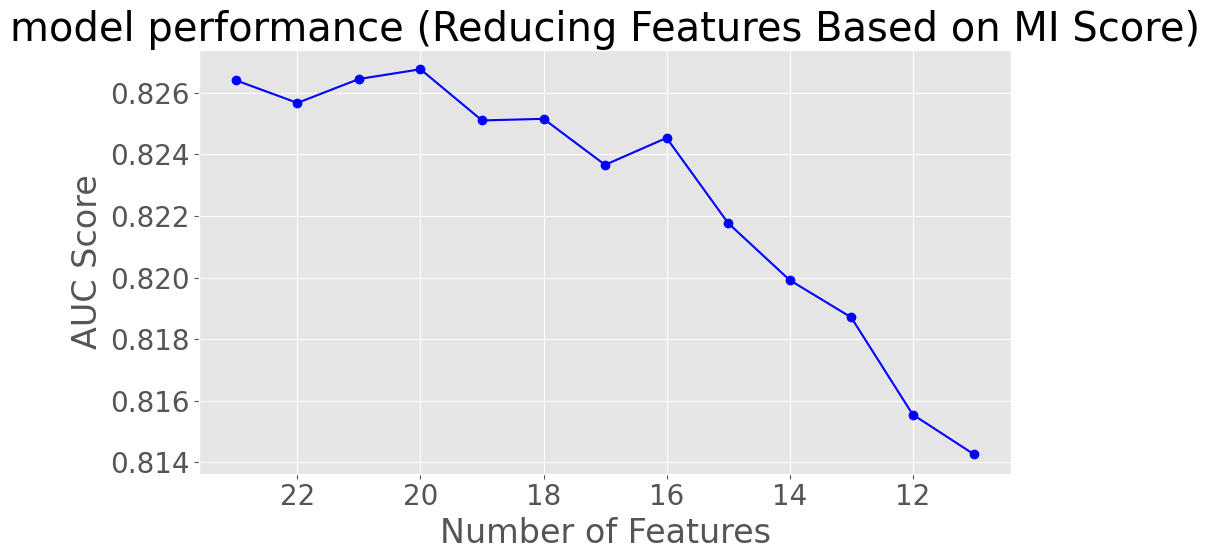

    Num_Features       AUC
0             23  0.826401
1             22  0.825669
2             21  0.826445
3             20  0.826761
4             19  0.825099
5             18  0.825152
6             17  0.823658
7             16  0.824533
8             15  0.821769
9             14  0.819919
10            13  0.818709
11            12  0.815555
12            11  0.814259


In [10]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import pandas as pd


X_train_copy = X_train.copy()
y_train_copy = y_train.copy()

mutual_info_scores_sorted = mutual_info_scores.sort_values(by='Mutual Info Score', ascending=False)

num_features = []
auc_scores = []


selected_features = mutual_info_scores_sorted['Feature'].values

for i in range(len(mutual_info_scores_sorted) - 10):
    X_train_selected = X_train_copy[selected_features]
    X_test_selected = X_test[selected_features]

    rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=5, max_features='sqrt', random_state=42)
    rf_model.fit(X_train_selected, y_train_copy)

    y_test_pred_proba = rf_model.predict_proba(X_test_selected)[:, 1]
    auc = roc_auc_score(y_test, y_test_pred_proba)

    num_features.append(len(selected_features))
    auc_scores.append(auc)

    selected_features = selected_features[:-1]

plt.figure(figsize=(10, 6))
plt.plot(num_features, auc_scores, marker='o', color='b')
plt.xlabel("Number of Features")
plt.ylabel("AUC Score")
plt.title("model performance (Reducing Features Based on MI Score)")
plt.gca().invert_xaxis()
plt.grid(True)
plt.tight_layout()
plt.show()


results_df = pd.DataFrame({"Num_Features": num_features, "AUC": auc_scores})
print(results_df)

    Num_Features       AUC
0             23  0.826960
1             22  0.826037
2             21  0.824904
3             20  0.825119
4             19  0.824674
5             18  0.822624
6             17  0.821895
7             16  0.821959
8             15  0.820813
9             14  0.820890
10            13  0.818262
11            12  0.816604
12            11  0.814832


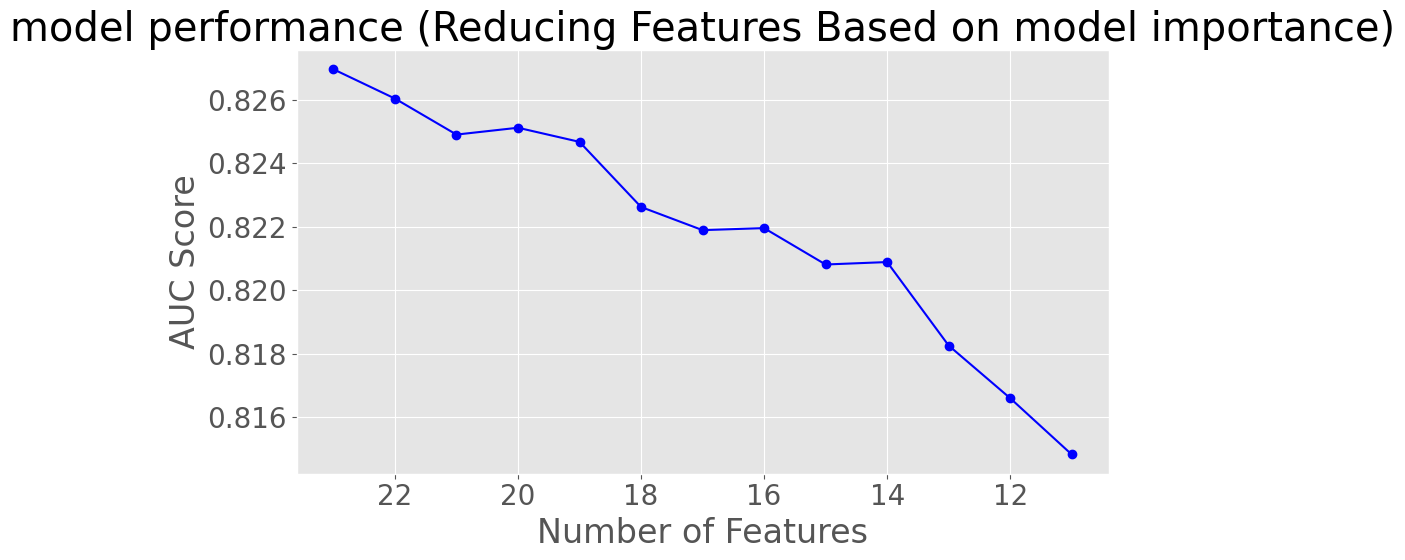

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt


X_train_copy = X_train.copy()
X_test_copy = X_test.copy()


rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=5, max_features='sqrt', random_state=42)
rf_model.fit(X_train_copy, y_train)

importances = rf_model.feature_importances_
features = X_train_copy.columns

feature_importances = pd.DataFrame({"Feature": features, "Importance": importances})
feature_importances = feature_importances.sort_values(by="Importance", ascending=False).reset_index(drop=True)

target_num_features = 10

results = []

current_features = feature_importances["Feature"].tolist()

while len(current_features) > target_num_features:
    X_train_selected = X_train_copy[current_features]
    X_test_selected = X_test_copy[current_features]

    model = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=5, max_features='sqrt', random_state=42)
    model.fit(X_train_selected, y_train)

    y_test_pred_proba = model.predict_proba(X_test_selected)[:, 1]
    auc = roc_auc_score(y_test, y_test_pred_proba)

    results.append({
        "Num_Features": len(current_features),
        "AUC": auc
    })

    current_features.pop()

results_df = pd.DataFrame(results)
print(results_df)

plt.figure(figsize=(10, 6))
plt.plot(results_df["Num_Features"], results_df["AUC"], marker='o', color='b')
plt.xlabel("Number of Features")
plt.ylabel("AUC Score")
plt.title("model performance (Reducing Features Based on model importance)")
plt.gca().invert_xaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [13]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score


random_forest = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=5, max_features='sqrt', random_state=42)

cv_results = cross_validate(
    random_forest, X_train, y_train,
    cv=5,
    scoring=['accuracy', 'roc_auc', 'f1_macro'],
    return_train_score=False
)


print("Cross-validation results:")
print("Cross ACC:", cv_results['test_accuracy'])
print("Cross AUC:", cv_results['test_roc_auc'])
print("Cross F1 (macro):", cv_results['test_f1_macro'])
print("Average ACC:", cv_results['test_accuracy'].mean())
print("Average AUC:", cv_results['test_roc_auc'].mean())
print("Average F1 (macro):", cv_results['test_f1_macro'].mean())


random_forest.fit(X_train, y_train)
y_test_pred = random_forest.predict(X_test)
y_test_pred_proba = random_forest.predict_proba(X_test)[:, 1]

print("\nTest set evaluation:")
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test AUC:", roc_auc_score(y_test, y_test_pred_proba))
print("Classification Report:\n", classification_report(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

Cross-validation results:
Cross ACC: [0.73193473 0.74825175 0.73970474 0.74222999 0.74067599]
Cross AUC: [0.80721117 0.82190513 0.81310282 0.81831313 0.82034208]
Cross F1 (macro): [0.72658653 0.74239853 0.7339985  0.73692559 0.73515921]
Average ACC: 0.7405594405594405
Average AUC: 0.816174865569419
Average F1 (macro): 0.7350136739837848

Test set evaluation:
Test Accuracy: 0.7411435674331883
Test AUC: 0.8263569020522464
Classification Report:
               precision    recall  f1-score   support

         AKI       0.76      0.79      0.77      3597
     Non-AKI       0.72      0.68      0.70      2839

    accuracy                           0.74      6436
   macro avg       0.74      0.73      0.74      6436
weighted avg       0.74      0.74      0.74      6436

Confusion Matrix:
 [[2843  754]
 [ 912 1927]]


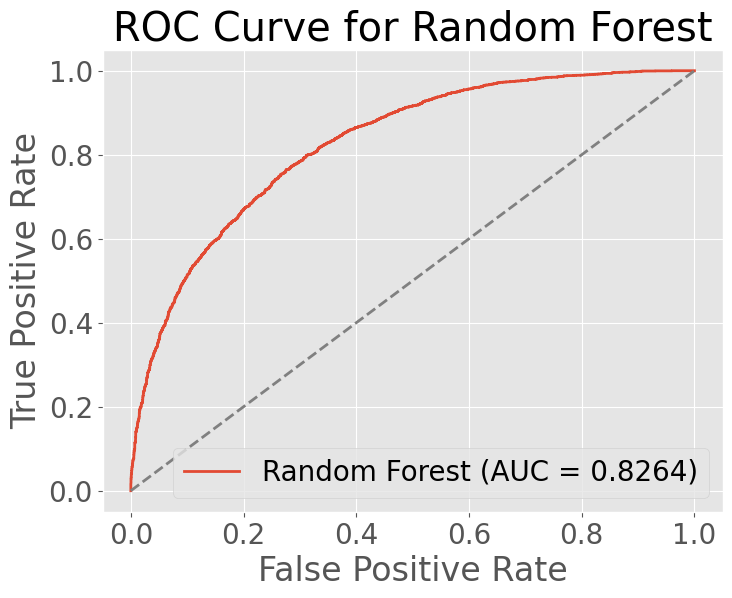

In [14]:
from sklearn.metrics import roc_auc_score,roc_curve,auc

y_test_numeric = y_test.apply(lambda x: 0 if x == 'AKI' else 1)


fpr, tpr, thresholds = roc_curve(y_test_numeric, y_test_pred_proba)
test_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2,  label=f'Random Forest (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2,linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest')
plt.legend(loc='lower right')
# plt.grid()
plt.show()

# Logistic Regression Implementation

In [15]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif, RFE
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Assuming 'df_imputed' is the DataFrame with imputed data
X = df_training.drop(['aki_status'], axis=1)  # Remove 'subject_id' and select all feature columns
y = df_training['aki_status'].apply(lambda x: 1 if x == 'AKI' else 0)  # Convert AKI status to binary classification

# 1. Reorder features using Variance Threshold
selector = VarianceThreshold(threshold=0.01)
X_var = selector.fit_transform(X)
selected_features_var = X.columns[selector.get_support()]  # Get selected feature names

# Sort based on variance (highest variance first)
variances = selector.variances_[selector.get_support()]
var_df = pd.DataFrame({'feature': selected_features_var, 'variance': variances})
selected_features_var = var_df.sort_values(by='variance', ascending=False)['feature'].tolist()

# 2. Reorder features using Mutual Information
mi_selector = SelectKBest(mutual_info_classif, k=len(selected_features_var))
mi_selector.fit(X[selected_features_var], y)
mi_scores = mi_selector.scores_
mi_df = pd.DataFrame({'feature': selected_features_var, 'mi_score': mi_scores})
selected_features_mi = mi_df.sort_values(by='mi_score', ascending=False)['feature'].tolist()

# 3. Reorder features using Random Forest
forest = RandomForestClassifier(random_state=0)
forest.fit(X[selected_features_mi], y)
importances = forest.feature_importances_
importance_df = pd.DataFrame({
    'feature': selected_features_mi,
    'importance': importances
}).sort_values(by='importance', ascending=False)
selected_features_rf = importance_df['feature'].tolist()

# 4. Reorder features using Recursive Feature Elimination (RFE)
rfe_selector = RFE(estimator=forest, n_features_to_select=len(selected_features_rf))
rfe_selector.fit(X[selected_features_rf], y)
rfe_ranking = rfe_selector.ranking_
rfe_df = pd.DataFrame({'feature': selected_features_rf, 'ranking': rfe_ranking})
selected_features_rfe = rfe_df.sort_values(by='ranking')['feature'].tolist()

# Output the final ordered features for each method
print("Ordered features by Variance Threshold:", selected_features_var)
print("Ordered features by Mutual Information:", selected_features_mi)
print("Ordered features by Random Forest:", selected_features_rf)
print("Ordered features by RFE:", selected_features_rfe)

Ordered features by Variance Threshold: ['systolic_bp_max', 'diastolic_bp_max', 'platelet_max', 'platelet_min', 'ptt_max', 'heart_rate_max', 'systolic_bp_min', 'bun_max', 'heart_rate_min', 'bun_min', 'ptt_min', 'diastolic_bp_min', 'avg_urine_output_per_kg', 'hemoglobin_min', 'hemoglobin_max', 'creatinine_max', 'creatinine_min', 'inr_max', 'calcium_max', 'potassium_max', 'calcium_min', 'potassium_min', 'inr_min']
Ordered features by Mutual Information: ['avg_urine_output_per_kg', 'inr_max', 'hemoglobin_min', 'bun_max', 'creatinine_max', 'ptt_max', 'systolic_bp_min', 'platelet_min', 'inr_min', 'diastolic_bp_min', 'potassium_max', 'ptt_min', 'hemoglobin_max', 'platelet_max', 'creatinine_min', 'heart_rate_max', 'bun_min', 'calcium_min', 'heart_rate_min', 'diastolic_bp_max', 'potassium_min', 'calcium_max', 'systolic_bp_max']
Ordered features by Random Forest: ['avg_urine_output_per_kg', 'hemoglobin_min', 'systolic_bp_min', 'platelet_min', 'ptt_max', 'ptt_min', 'bun_max', 'diastolic_bp_min',

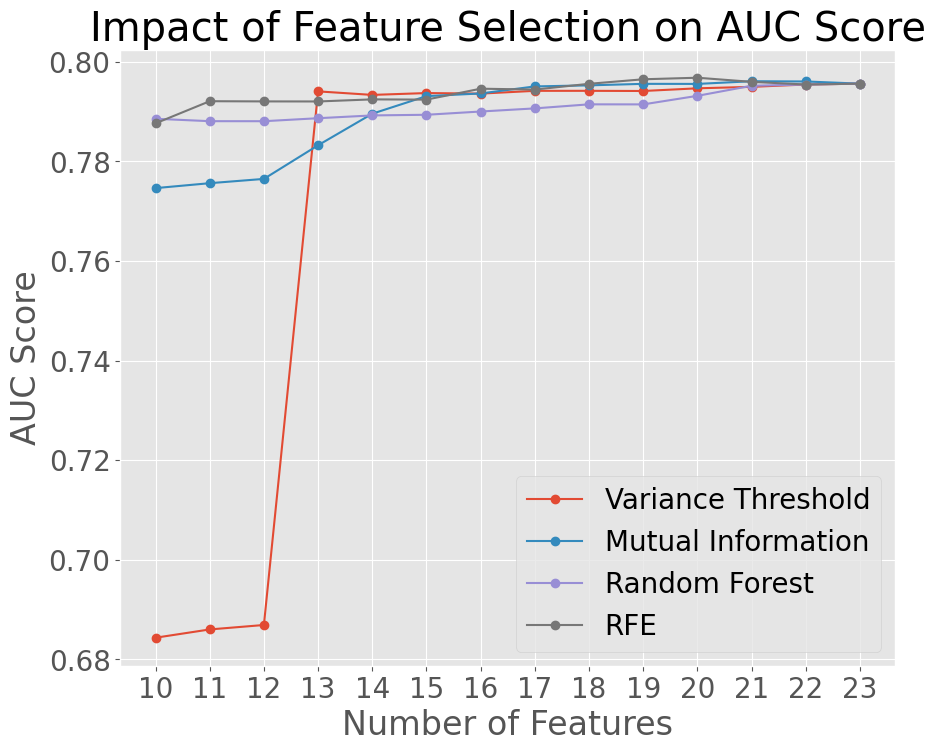

Optimal AUC Score: 0.7968 achieved by RFE with 20 features
              precision    recall  f1-score      support
Non-AKI        0.731020  0.596038  0.656664  2827.000000
AKI            0.723554  0.828207  0.772351  3609.000000
accuracy       0.726227  0.726227  0.726227     0.726227
macro avg      0.727287  0.712123  0.714508  6436.000000
weighted avg   0.726833  0.726227  0.721536  6436.000000


In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Standardize features
scaler = StandardScaler()
# X = df_imputed.drop(columns=['aki_status', 'subject_id'])  # Data before scaling for feature name reference
X_scaled = scaler.fit_transform(X)  # Scaled data
y = df_training['aki_status'].apply(lambda x: 1 if x == 'AKI' else 0)  # Define binary target variable

# Initialize lists to store AUC scores for different feature selection methods
feature_counts = list(range(len(selected_features_rfe), 9, -1))  # Range of feature counts from max to 10
auc_scores = {'Variance Threshold': [], 'Mutual Information': [], 'Random Forest': [], 'RFE': []}
logistic_model = LogisticRegression(max_iter=2000, random_state=42)

# Initialize variables to track the best AUC score
best_auc = 0
best_method = ""
best_feature_count = 0

# Calculate AUC for a given set of features by name
def calculate_auc(X_scaled, y, feature_names):
    feature_indices = [X.columns.get_loc(feature) for feature in feature_names]  # Get column indices
    X_selected = X_scaled[:, feature_indices]  # Select scaled features based on indices
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
    logistic_model.fit(X_train, y_train)
    y_proba = logistic_model.predict_proba(X_test)[:, 1]
    return roc_auc_score(y_test, y_proba)

# Iterate over different feature counts
for count in feature_counts:
    # 1. Variance Threshold
    features_var = selected_features_var[:count]
    auc_var = calculate_auc(X_scaled, y, features_var)
    auc_scores['Variance Threshold'].append(auc_var)
    if auc_var > best_auc:
        best_auc, best_method, best_feature_count = auc_var, 'Variance Threshold', count

    # 2. Mutual Information
    features_mi = selected_features_mi[:count]
    auc_mi = calculate_auc(X_scaled, y, features_mi)
    auc_scores['Mutual Information'].append(auc_mi)
    if auc_mi > best_auc:
        best_auc, best_method, best_feature_count = auc_mi, 'Mutual Information', count

    # 3. Random Forest
    features_rf = selected_features_rf[:count]
    auc_rf = calculate_auc(X_scaled, y, features_rf)
    auc_scores['Random Forest'].append(auc_rf)
    if auc_rf > best_auc:
        best_auc, best_method, best_feature_count = auc_rf, 'Random Forest', count

    # 4. Recursive Feature Elimination (RFE)
    features_rfe = selected_features_rfe[:count]
    auc_rfe = calculate_auc(X_scaled, y, features_rfe)
    auc_scores['RFE'].append(auc_rfe)
    if auc_rfe > best_auc:
        best_auc, best_method, best_feature_count = auc_rfe, 'RFE', count

# Plot AUC score trends
plt.figure(figsize=(10, 8))
for method, scores in auc_scores.items():
    plt.plot(feature_counts, scores, marker='o', label=method)

plt.xlabel('Number of Features')
plt.ylabel('AUC Score')
plt.title('Impact of Feature Selection on AUC Score')
plt.legend()

# Set x-axis to show only integer values
plt.xticks(feature_counts)  # Ensures only integer ticks are shown

plt.show()


# Output the optimal AUC score
print(f"Optimal AUC Score: {best_auc:.4f} achieved by {best_method} with {best_feature_count} features")

from sklearn.metrics import classification_report
import pandas as pd

# Select the optimal feature set
if best_method == 'Variance Threshold':
    best_features = selected_features_var[:best_feature_count]
elif best_method == 'Mutual Information':
    best_features = selected_features_mi[:best_feature_count]
elif best_method == 'Random Forest':
    best_features = selected_features_rf[:best_feature_count]
else:  # RFE
    best_features = selected_features_rfe[:best_feature_count]

# Get indices of the best features for X_scaled
best_feature_indices = [X.columns.get_loc(feature) for feature in best_features]
X_selected_optimal = X_scaled[:, best_feature_indices]

# Split the dataset based on the optimal feature set
X_train_optimal, X_test_optimal, y_train, y_test = train_test_split(X_selected_optimal, y, test_size=0.2, random_state=42)

# Train and evaluate the logistic regression model on the optimal feature set
logistic_model.fit(X_train_optimal, y_train)
y_pred = logistic_model.predict(X_test_optimal)

# Generate classification report
report = classification_report(y_test, y_pred, target_names=['Non-AKI', 'AKI'], output_dict=True)

# Convert report to DataFrame for formatted output
report_df = pd.DataFrame(report).transpose()
print(report_df)

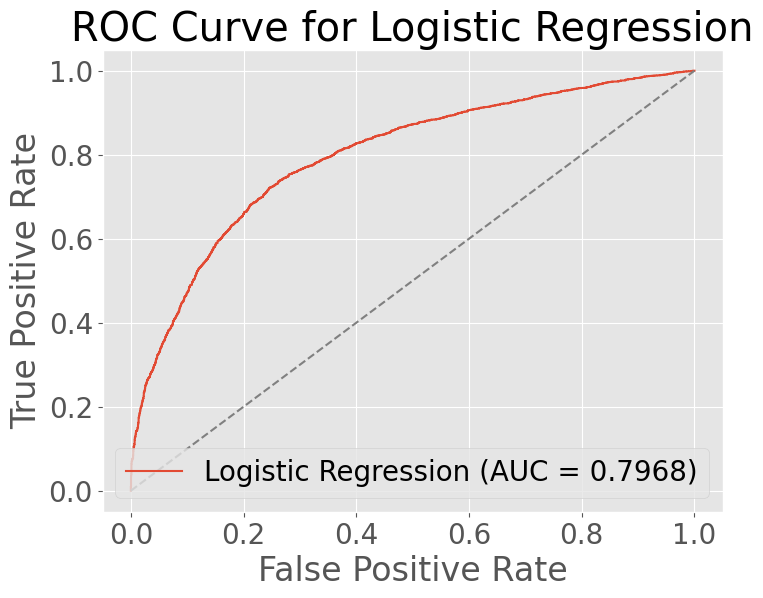

In [17]:
y_test_pred_proba = logistic_model.predict_proba(X_test_optimal)[:, 1]


test_auc = roc_auc_score(y_test, y_test_pred_proba)




fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc="lower right")

plt.show()